In [6]:
import numpy as np
import keras.backend as K
import keras.initializers as initializers
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop, Adadelta
from keras.layers import Input, Activation, Add, AveragePooling3D
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Conv3D, Cropping3D
from keras.layers.pooling import MaxPooling3D
from keras.layers.wrappers import TimeDistributed, Bidirectional

# visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# Simple model

In [7]:
def unet():
    
    # block 1
#     input_1 = Input(shape=(1,108,284,228), name="input_1")
    input_1 = Input(shape=(1,142,322,262), name="input_1")
    conv_1 = Conv3D(filters=6, kernel_size=(1,5,5), 
                    data_format="channels_first", name="conv_1")(input_1)
    relu_2 = Activation('relu', name="ReLU_2")(conv_1)
    down_3 = Conv3D(filters=8, kernel_size=(1,1,1), strides=(2,2,2),
                      data_format="channels_first", name="down_3")(relu_2)

    # block 2
    relu_4 = Activation('relu', name="ReLU_4")(down_3)
    conv_5 = Conv3D(filters=8, kernel_size=(1,5,5), data_format="channels_first", name="conv_5")(relu_4)
    relu_6 = Activation("relu", name="ReLU_6")(conv_5)
    conv_7 = Conv3D(filters=8, kernel_size=(1,5,5), data_format="channels_first", name="conv_7")(relu_6)

    # skip connection 1
    crop_9 = Cropping3D(cropping=((0,0), (4,4), (4,4)), 
                              data_format="channels_first", name="crop_9")(down_3)
    merge_8 = Add(name="merge_8")([conv_7, crop_9])

    # block 3
    relu_10 = Activation("relu", name="ReLU_10")(merge_8)
    conv_11 = Conv3D(filters=8, kernel_size=(1,5,5), data_format="channels_first", name="conv_11")(relu_10)
    relu_12 = Activation("relu", name="ReLU_12")(conv_11)
    conv_13 = Conv3D(filters=8, kernel_size=(1,5,5), data_format="channels_first", name="conv_13")(relu_12)

    # skip connection 2
    crop_15 = Cropping3D(cropping=((0,0), (4,4), (4,4)), 
                              data_format="channels_first", name="crop_15")(merge_8)
    merge_14 = Add(name="merge_14")([conv_13, crop_15])

    # block 4
    relu_16 = Activation("relu", name="ReLU_16")(merge_14)
    down_17 = Conv3D(filters=16, kernel_size=(1,1,1), strides=(1,2,2),
                     data_format="channels_first", name="down_17")(relu_16)
    relu_18 = Activation("relu", name="ReLU_18")(down_17)
    conv_19 = Conv3D(filters=16, kernel_size=(1,3,3), data_format="channels_first", name="conv_19")(relu_18)
    relu_20 = Activation("relu", name="ReLU_20")(conv_19)
    conv_21 = Conv3D(filters=16, kernel_size=(1,1,1), data_format="channels_first", name="conv_21")(relu_20)

    # skip connection 3
    crop_23 = Cropping3D(cropping=((0,0), (1,1), (1,1)), 
                         data_format="channels_first", name="crop_23")(down_17)
    merge_22 = Add(name="merge_22")([conv_21, crop_23])

    # block 5
    relu_24 = Activation("relu", name="ReLU_24")(merge_22)
    conv_25 = Conv3D(filters=16, kernel_size=(1,3,3), data_format="channels_first", name="conv_25")(relu_24)
    relu_26 = Activation("relu", name="ReLU_26")(conv_25)
    conv_27 = Conv3D(filters=16, kernel_size=(1,1,1), data_format="channels_first", name="conv_27")(relu_26)

    # skip connection 4
    crop_29 = Cropping3D(cropping=((0,0), (1,1), (1,1)), 
                              data_format="channels_first", name="crop_29")(merge_22)
    merge_28 = Add(name="merge_28")([conv_27, crop_29])

    # block 6
    relu_30 = Activation("relu", name="ReLU_30")(merge_28)
    down_31 = Conv3D(filters=32, kernel_size=(1,1,1), strides=(1,2,2),
                      data_format="channels_first", name="down_31")(relu_30)
    relu_32 = Activation("relu", name="ReLU_32")(down_31)
    conv_33 = Conv3D(filters=32, kernel_size=(1,1,1), data_format="channels_first", name="conv_33")(relu_32)
    relu_34 = Activation("relu", name="ReLU_34")(conv_33)
    conv_35 = Conv3D(filters=32, kernel_size=(1,1,1), data_format="channels_first", name="conv_35")(relu_34)

    # skip connection 5
    merge_36 = Add(name="merge_36")([conv_35, down_31])

    # block 7
    relu_37 = Activation("relu", name="ReLU_37")(merge_36)
    conv_38 = Conv3D(filters=32, kernel_size=(1,1,1), data_format="channels_first", name="conv_38")(relu_37)
    relu_39 = Activation("relu", name="ReLU_39")(conv_38)
    conv_40 = Conv3D(filters=32, kernel_size=(1,1,1), data_format="channels_first", name="conv_40")(relu_39)

    # skip connection 6
    merge_41 = Add(name="merge_41")([conv_40, merge_36])

    # block 8
    relu_42 = Activation("relu", name="ReLU_42")(merge_41)
    down_43 = AveragePooling3D(pool_size=(54,29,22), data_format="channels_first", 
                               name="down_43")(relu_42)
    conv_44 = Conv3D(filters=1, kernel_size=(1,1,1), data_format="channels_first", name="conv_44")(down_43)
    
    model = Model(inputs=input_1, outputs=conv_44)
    
    return model

In [8]:
model = unet()

# to file
# plot_model(model, to_file='model_single.png', show_shapes=True)

# to notebook
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Time distributed model

In [14]:
def tdist_unet(timesteps = 1):

    # block 1
#     input_1 = Input(shape=(timesteps,1,108,284,228), name="input_1") # timesteps x channels x imgsize
    input_1 = Input(shape=(timesteps,1,142,322,262), name="input_1") # timesteps x channels x imgsize
    conv_1 = TimeDistributed(Conv3D(filters=6, kernel_size=(1,5,5), data_format="channels_first", name="conv_1"), name="TD_conv_1")(input_1)
    relu_2 = TimeDistributed(Activation('relu', name="ReLU_2"), name="TD_ReLU_2")(conv_1)
    down_3 = TimeDistributed(Conv3D(filters=8, kernel_size=(1,1,1), strides=(2,2,2), data_format="channels_first", name="down_3"), name="TD_down_3")(relu_2)

    # block 2
    relu_4 = TimeDistributed(Activation('relu', name="ReLU_4"), name="TD_ReLU_4")(down_3)
    conv_5 = TimeDistributed(Conv3D(filters=8, kernel_size=(1,5,5), data_format="channels_first", name="conv_5"), name="TD_conv_5")(relu_4)
    relu_6 = TimeDistributed(Activation("relu", name="ReLU_6"), name="TD_ReLU_6")(conv_5)
    conv_7 = TimeDistributed(Conv3D(filters=8, kernel_size=(1,5,5), data_format="channels_first", name="conv_7"), name="TD_conv_7")(relu_6)

    # skip connection 1
    crop_9 = TimeDistributed(Cropping3D(cropping=((0,0), (4,4), (4,4)), data_format="channels_first", name="crop_9"), name="TD_crop_9")(down_3)
    merge_8 = Add(name="merge_8")([conv_7, crop_9])

    # block 3
    relu_10 = TimeDistributed(Activation("relu", name="ReLU_10"), name="TD_ReLU_10")(merge_8)
    conv_11 = TimeDistributed(Conv3D(filters=8, kernel_size=(1,5,5), data_format="channels_first", name="conv_11"), name="TD_conv_11")(relu_10)
    relu_12 = TimeDistributed(Activation("relu", name="ReLU_12"), name="TD_ReLU_12")(conv_11)
    conv_13 = TimeDistributed(Conv3D(filters=8, kernel_size=(1,5,5), data_format="channels_first", name="conv_13"), name="TD_conv_13")(relu_12)

    # skip connection 2
    crop_15 = TimeDistributed(Cropping3D(cropping=((0,0), (4,4), (4,4)), data_format="channels_first", name="crop_15"), name="TD_crop_15")(merge_8)
    merge_14 = Add(name="merge_14")([conv_13, crop_15])

    # block 4
    relu_16 = TimeDistributed(Activation("relu", name="ReLU_16"), name="TD_ReLU_16")(merge_14)
    down_17 = TimeDistributed(Conv3D(filters=16, kernel_size=(1,1,1), strides=(1,2,2), data_format="channels_first", name="down_17"), name="TD_down_17")(relu_16)
    relu_18 = TimeDistributed(Activation("relu", name="ReLU_18"), name="TD_ReLU_18")(down_17)
    conv_19 = TimeDistributed(Conv3D(filters=16, kernel_size=(1,3,3), data_format="channels_first", name="conv_19"), name="TD_conv_19")(relu_18)
    relu_20 = TimeDistributed(Activation("relu", name="ReLU_20"), name="TD_ReLU_20")(conv_19)
    conv_21 = TimeDistributed(Conv3D(filters=16, kernel_size=(1,1,1), data_format="channels_first", name="conv_21"), name="TD_conv_21")(relu_20)

    # skip connection 3
    crop_23 = TimeDistributed(Cropping3D(cropping=((0,0), (1,1), (1,1)), data_format="channels_first", name="crop_23"), name="TD_crop_23")(down_17)
    merge_22 = Add(name="merge_22")([conv_21, crop_23])

    # block 5
    relu_24 = TimeDistributed(Activation("relu", name="ReLU_24"), name="TD_ReLU_24")(merge_22)
    conv_25 = TimeDistributed(Conv3D(filters=16, kernel_size=(1,3,3), data_format="channels_first", name="conv_25"), name="TD_conv_25")(relu_24)
    relu_26 = TimeDistributed(Activation("relu", name="ReLU_26"), name="TD_ReLU_26")(conv_25)
    conv_27 = TimeDistributed(Conv3D(filters=16, kernel_size=(1,1,1), data_format="channels_first", name="conv_27"), name="TD_conv_27")(relu_26)

    # skip connection 4
    crop_29 = TimeDistributed(Cropping3D(cropping=((0,0), (1,1), (1,1)), data_format="channels_first", name="crop_29"), name="TD_crop_29")(merge_22)
    merge_28 = Add(name="merge_28")([conv_27, crop_29])

    # block 6
    relu_30 = TimeDistributed(Activation("relu", name="ReLU_30"), name="TD_ReLU_30")(merge_28)
    down_31 = TimeDistributed(Conv3D(filters=32, kernel_size=(1,1,1), strides=(1,2,2), data_format="channels_first", name="down_31"), name="TD_down_31")(relu_30)
    relu_32 = TimeDistributed(Activation("relu", name="ReLU_32"), name="TD_ReLU_32")(down_31)
    conv_33 = TimeDistributed(Conv3D(filters=32, kernel_size=(1,1,1), data_format="channels_first", name="conv_33"), name="TD_conv_33")(relu_32)
    relu_34 = TimeDistributed(Activation("relu", name="ReLU_34"), name="TD_ReLU_34")(conv_33)
    conv_35 = TimeDistributed(Conv3D(filters=32, kernel_size=(1,1,1), data_format="channels_first", name="conv_35"), name="TD_conv_35")(relu_34)

    # skip connection 5
    merge_36 = Add(name="merge_36")([conv_35, down_31])

    # block 7
    relu_37 = TimeDistributed(Activation("relu", name="ReLU_37"), name="TD_ReLU_37")(merge_36)
    conv_38 = TimeDistributed(Conv3D(filters=32, kernel_size=(1,1,1), data_format="channels_first", name="conv_38"), name="TD_conv_38")(relu_37)
    relu_39 = TimeDistributed(Activation("relu", name="ReLU_39"), name="TD_ReLU_39")(conv_38)
    conv_40 = TimeDistributed(Conv3D(filters=32, kernel_size=(1,1,1), data_format="channels_first", name="conv_40"), name="TD_conv_40")(relu_39)

    # skip connection 6
    merge_41 = Add(name="merge_41")([conv_40, merge_36])

    # block 8
    relu_42 = TimeDistributed(Activation("relu", name="ReLU_42"), name="TD_ReLU_42")(merge_41)
    down_43 = TimeDistributed(AveragePooling3D(pool_size=(54,29,22), data_format="channels_first", name="down_43"), name="TD_down_43")(relu_42)
    conv_44 = TimeDistributed(Conv3D(filters=1, kernel_size=(1,1,1), data_format="channels_first", name="conv_44"), name="TD_conv_44")(down_43)
    
    model = Model(inputs=input_1, outputs=conv_44)
    
    return model

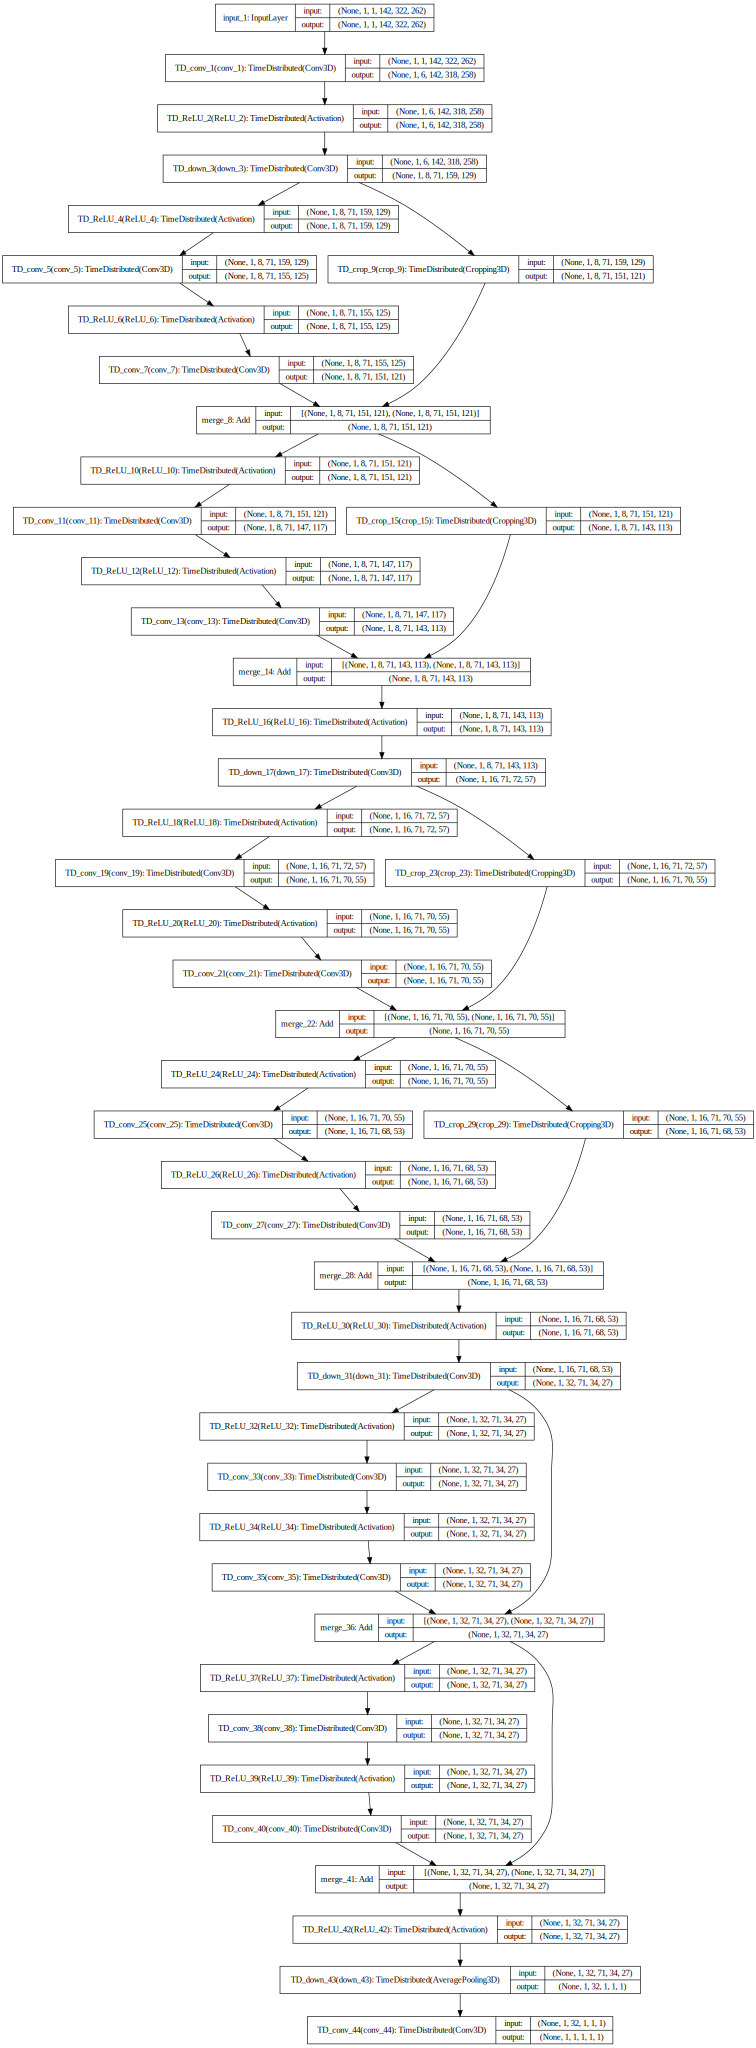

In [15]:
model = tdist_unet(timesteps=1)

# to file
# plot_model(model, to_file='model_timedist.png', show_shapes=True)

# to notebook
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
# model.summary()

----